In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator
import tomllib
import tomlkit as tml
import json
import xarray as xr
import csvb.ingest as ci
import plotly.express as px
import plotly.graph_objects as go
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True

In [2]:
HOME = pathlib.Path.home()
cfgpth = HOME / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
RULESPTH = HOME / cfg["paths"]["rules"]
BANKPTH = HOME / cfg["paths"]["bank"]
PRODUCTSPTH = HOME / cfg["paths"]["products"]

In [3]:
fd  = ci.find_bank_files(HOME / pathlib.Path(cfg["paths"]["bank"])) 

In [4]:
try:
    del apl
except NameError:
    pass
apl = ci.ingest_bank_files(fd["Liabilities:Apple:Credit Card"]["files"],
                           fd["Liabilities:Apple:Credit Card"],
                           RULESPTH)

apl = ci.read_and_apply(apl, RULESPTH / fd["Liabilities:Apple:Credit Card"]["rules_file"])
apl[apl["From"] == ""]

Empty DataFrame
Columns: [Transaction Date, Clearing Date, Description, Merchant, Category, Type, Amount (USD), Purchased By, Amount, From]
Index: []

In [5]:
try:
    del apl_inc
except NameError:
    pass
apl_inc = ci.ingest_bank_files(fd["Liabilities:Apple:Installments"]["files"],
                           fd["Liabilities:Apple:Installments"],
                           RULESPTH)

apl_inc[apl_inc["From"] == ""]

Empty DataFrame
Columns: [Date, Description, Amount, From]
Index: []

In [6]:
try:
    del fst
except NameError:
    pass
fst = ci.ingest_bank_files(fd["Assets:1st Source:Checking"]["files"],
                           fd["Assets:1st Source:Checking"],
                           RULESPTH)

fst = ci.read_and_apply(fst, RULESPTH / fd["Assets:1st Source:Checking"]["rules_file"])

fst[fst["From"] == ""]

Empty DataFrame
Columns: [Transaction Number, Date, Description, Memo, Amount Debit, Amount Credit, Balance, Amount, From, Check Number, Fees  ]
Index: []

In [7]:
try:
    del ally
except NameError:
    pass
ally = ci.ingest_bank_files(fd["Assets:Ally:Savings"]["files"],
                           fd["Assets:Ally:Savings"],
                           RULESPTH)

ally = ci.read_and_apply(ally, RULESPTH / fd["Assets:Ally:Savings"]["rules_file"])

ally[ally["From"] == ""]

Empty DataFrame
Columns: [Date, Time, Amount, Type, Description, From]
Index: []

In [8]:
try:
    del ndfcu
except NameError:
    pass
ndfcu = ci.ingest_bank_files(fd["Liabilities:NDFCU:Credit Card"]["files"],
                           fd["Liabilities:NDFCU:Credit Card"],
                           RULESPTH)

ndfcu = ci.read_and_apply(ndfcu, RULESPTH / fd["Liabilities:NDFCU:Credit Card"]["rules_file"])

ndfcu[ndfcu["From"] == ""]
ndfcu[pd.isnull(ndfcu["From"])]

Empty DataFrame
Columns: [Date, Note, Description, Amount, Balance, From]
Index: []

In [9]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu,
              "Liabilities:Apple:Installments": apl_inc}


trans = ci.to_transactions(bank_tables)
trans = trans.sort_values("Date")
trans

Date                                        Description   Amount  \
0    2021-12-31  MARTIN S SUPERMARKE      . SOUTHBEND    . IN 0000   -86.95   
1    2021-12-31  PHILLIPS 66 - 0082 FIR   . MISHAWAKA    . IN 0000   -26.93   
2    2021-12-31  FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...   -11.04   
3    2021-12-31  APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...   -14.99   
4    2022-01-01  CVS/PHARMACY #08642      . SOUTH BEND   . IN 0000   -24.70   
...         ...                                                ...      ...   
2559 2024-04-30                     MONTHLY INSTALLMENTS (3 OF 12)  -114.08   
2555 2024-04-30                    MONTHLY INSTALLMENTS (24 OF 24)   -54.24   
2554 2024-04-30                     MONTHLY INSTALLMENTS (3 OF 12)   -23.25   
2556 2024-04-30                                 ND PAYROLL PAYROLL  5335.70   
2560 2024-05-10  Requested transfer from KEITH W DAVIS Ally Ban...   600.00   

                                From                             To  
0                 Expenses:Groceries  Liabilities:NDFCU:Credit Card  
1                 Expenses:Auto:Fuel  Liabilities:NDFCU:Credit Card  
2             Expenses:Entertainment  Liabilities:Apple:Credit Card  
3             Expenses:Subscriptions  Liabilities:Apple:Credit Card  
4              Expenses:Medical:Body  Liabilities:NDFCU:Credit Card  
...                              ...                            ...  
2559  Liabilities:Apple:Installments  Liabilities:Apple:Credit Card  
2555  Liabilities:Apple:Installments  Liabilities:Apple:Credit Card  
2554  Liabilities:Apple:Installments  Liabilities:Apple:Credit Card  
2556       Income:Notre Dame:Regular     Assets:1st Source:Checking  
2560                        Transfer            Assets:Ally:Savings  

[2561 rows x 5 columns]

In [10]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(HOME / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])

#bal_decl["From"] = ""
#bal["Amount"] = bal["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))
#bal_decl = bal_decl.sort_values("Date")
#bal_decl
#jan_bal = bal_decl.loc[(bal_decl["Date"] >= pd.Timestamp(2023, 12, 31)) &
#                       (bal_decl["Date"] <= pd.Timestamp(2024, 1, 1))
#trans = pd.concat([trans, bal_decl])
#bal_decl

In [11]:
try:
    del ledgers
except NameError:
    pass
    
#ledgers = create_ledgers(trans)
ledgers = {}
for acct in ci.accounts(trans):
    ledgers[acct] = ci.trans_to_ledger(trans, acct, bal_decl=bal_decl, clean=True)

#ledgers

In [12]:
cutoff_ledgers = dict()
none_in_period = []
for acct in ledgers:
    try:
        cutoff_ledgers[acct] = ledgers[acct][ledgers[acct]["Date"] >= pd.Timestamp(2023, 1, 1)]
    except IndexError as e:
        print(acct)
        raise e
    if len(cutoff_ledgers[acct]) == 0:
        none_in_period.append(acct)
        #print(acct)
        #cutoff_ledgers[acct] = ledgers[acct].iloc[-2:]
        

#cutoff_ledgers["Liabilities:Auto:Loan"].iloc[-2:-1]
cb = ci.balances(cutoff_ledgers)
cb

Period Start  \
Type        Account    Subaccount                                                    
Assets      1st Source Checking                                2023-01-03 00:00:00   
            Ally       Savings                                 2023-01-11 00:00:00   
Expenses    Amazon                                             2023-01-13 00:00:00   
            Auto                     Series([], Name: Date, dtype: datetime64[ns])   
                       Fuel                                    2023-01-16 00:00:00   
...                                                                            ...   
Liabilities Apple      Credit Card                             2023-01-01 00:00:00   
                       Installments                            2023-01-31 00:00:00   
            Auto       Loan                  Series([], Name: Date, dtype: object)   
            NDFCU      Credit Card                             2023-01-01 00:00:00   
Transfer                                                       2023-01-09 00:00:00   

                                     Initial Balance  \
Type        Account    Subaccount                      
Assets      1st Source Checking                    0   
            Ally       Savings                     0   
Expenses    Amazon                                 0   
            Auto                                   0   
                       Fuel                        0   
...                                              ...   
Liabilities Apple      Credit Card                 0   
                       Installments                0   
            Auto       Loan                        0   
            NDFCU      Credit Card                 0   
Transfer                                           0   

                                                                        Period End  \
Type        Account    Subaccount                                                    
Assets      1st Source Checking                                2024-04-30 00:00:00   
            Ally       Savings                                 2024-05-10 00:00:00   
Expenses    Amazon                                             2024-04-18 00:00:00   
            Auto                     Series([], Name: Date, dtype: datetime64[ns])   
                       Fuel                                    2024-04-11 00:00:00   
...                                                                            ...   
Liabilities Apple      Credit Card                             2024-04-30 00:00:00   
                       Installments                            2024-04-30 00:00:00   
            Auto       Loan                  Series([], Name: Date, dtype: object)   
            NDFCU      Credit Card                             2024-04-26 00:00:00   
Transfer                                                       2024-05-10 00:00:00   

                                     Ending Balance  Difference  
Type        Account    Subaccount                                
Assets      1st Source Checking             2821.51     2821.51  
            Ally       Savings              7625.69     7625.69  
Expenses    Amazon                           819.95      819.95  
            Auto                               0.00        0.00  
                       Fuel                 1008.74     1008.74  
...                                             ...         ...  
Liabilities Apple      Credit Card          -634.66     -634.66  
                       Installments         -237.29     -237.29  
            Auto       Loan                    0.00        0.00  
            NDFCU      Credit Card         -2196.53    -2196.53  
Transfer                                   -2436.25    -2436.25  

[62 rows x 5 columns]

In [13]:
longb = ci.balances(ledgers)

In [14]:
longb

Period Start  Initial Balance Period End  \
Type        Account    Subaccount                                              
Assets      1st Source Checking       2021-12-31          5067.54 2024-04-30   
            Ally       Savings        2022-12-09             0.00 2024-05-10   
Expenses    Amazon                    2022-01-15             0.00 2024-04-18   
            Auto                      2022-01-14             0.00 2022-01-14   
                       Fuel           2021-12-31             0.00 2024-04-11   
...                                          ...              ...        ...   
Liabilities Apple      Credit Card    2021-12-31         -2522.77 2024-04-30   
                       Installments   2021-12-31          -738.94 2024-04-30   
            Auto       Loan           2022-01-01         -4216.71 2022-07-11   
            NDFCU      Credit Card    2021-12-31             0.00 2024-04-26   
Transfer                              2022-01-07             0.00 2024-05-10   

                                     Ending Balance  Difference  
Type        Account    Subaccount                                
Assets      1st Source Checking        6.675630e+03     1608.09  
            Ally       Savings         8.235860e+03     8235.86  
Expenses    Amazon                     2.328620e+03     2328.62  
            Auto                       9.620000e+00        9.62  
                       Fuel            1.930620e+03     1930.62  
...                                             ...         ...  
Liabilities Apple      Credit Card    -1.572510e+03      950.26  
                       Installments   -1.836990e+03    -1098.05  
            Auto       Loan            3.410605e-13     4216.71  
            NDFCU      Credit Card    -6.657800e+02     -665.78  
Transfer                              -7.003870e+03    -7003.87  

[62 rows x 5 columns]

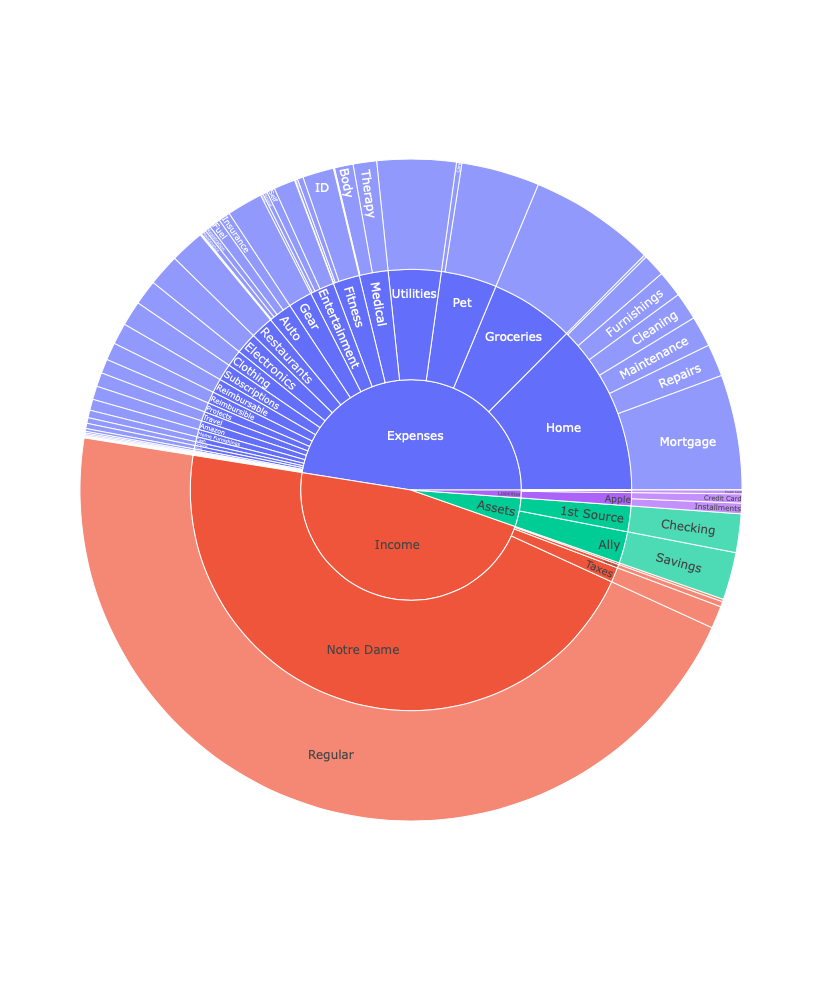

In [15]:
df = longb
df = pd.DataFrame({"Type": df.index.get_level_values("Type"),
                   "Account": df.index.get_level_values("Account"),
                   "Subaccount": df.index.get_level_values("Subaccount"),
                  "Ending Balance": df["Ending Balance"].apply(np.abs)})
df = df.loc[df["Type"] != "Transfer"]
#df = df.loc[
sbfig = px.sunburst(df, path=["Type", "Account", "Subaccount"], values="Ending Balance")
sbfig.update_layout(height=1000)


In [16]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])

In [17]:
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))
flow_df

Amount
From                          To                                     
Assets:1st Source:Checking    Expenses:Auto:Insurance         2042.05
                              Expenses:Auto:Registration       260.35
                              Expenses:Cash                   1313.25
                              Expenses:Fitness:Equipment       100.00
                              Expenses:Fitness:ID             5400.00
...                                                               ...
Liabilities:NDFCU:Credit Card Transfer                         177.63
Transfer                      Assets:1st Source:Checking      9981.50
                              Assets:Ally:Savings            10800.00
                              Liabilities:Apple:Credit Card  55890.41
                              Liabilities:NDFCU:Credit Card  57764.73

[108 rows x 1 columns]

In [18]:
accts = list(ci.accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )


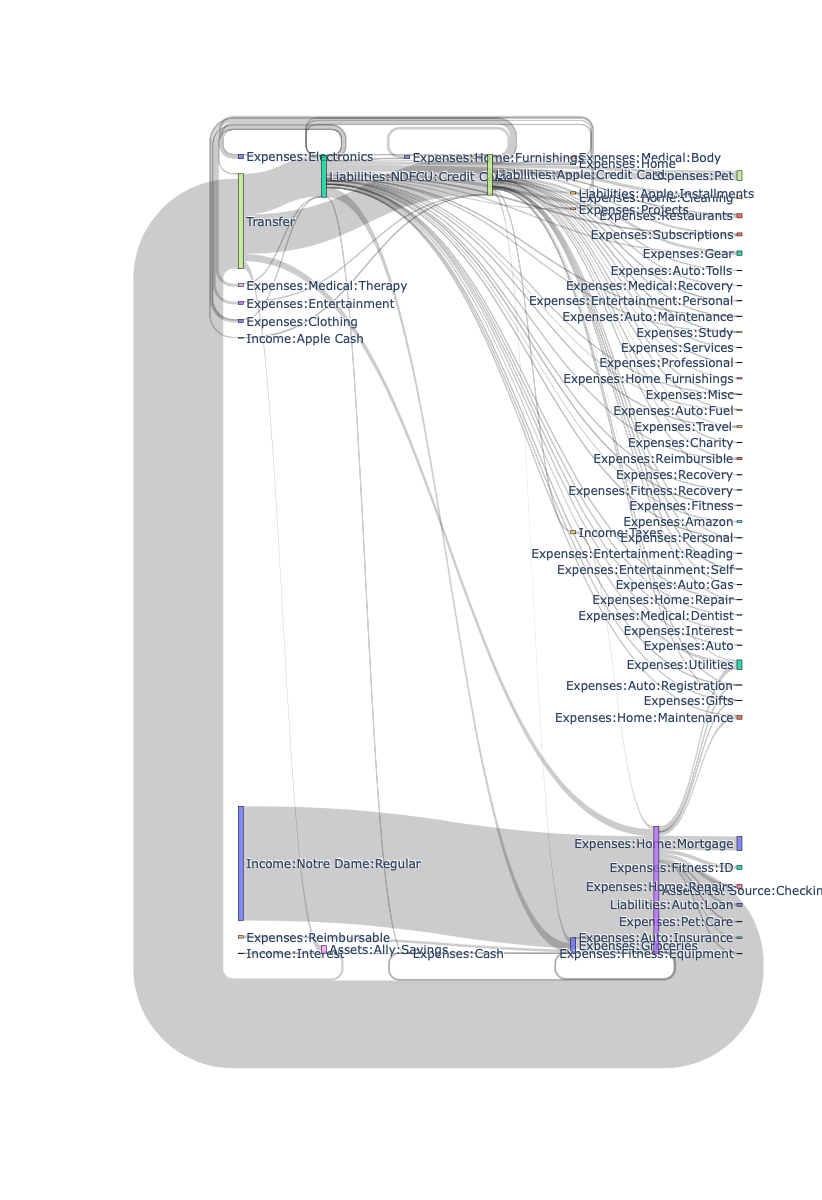

In [19]:
f.update_layout(height=1200)
f.show()

In [20]:
bank_tables.keys()

dict_keys(['Assets:1st Source:Checking', 'Liabilities:Apple:Credit Card', 'Assets:Ally:Savings', 'Liabilities:NDFCU:Credit Card', 'Liabilities:Apple:Installments'])

In [21]:
cb

Period Start  \
Type        Account    Subaccount                                                    
Assets      1st Source Checking                                2023-01-03 00:00:00   
            Ally       Savings                                 2023-01-11 00:00:00   
Expenses    Amazon                                             2023-01-13 00:00:00   
            Auto                     Series([], Name: Date, dtype: datetime64[ns])   
                       Fuel                                    2023-01-16 00:00:00   
...                                                                            ...   
Liabilities Apple      Credit Card                             2023-01-01 00:00:00   
                       Installments                            2023-01-31 00:00:00   
            Auto       Loan                  Series([], Name: Date, dtype: object)   
            NDFCU      Credit Card                             2023-01-01 00:00:00   
Transfer                                                       2023-01-09 00:00:00   

                                     Initial Balance  \
Type        Account    Subaccount                      
Assets      1st Source Checking                    0   
            Ally       Savings                     0   
Expenses    Amazon                                 0   
            Auto                                   0   
                       Fuel                        0   
...                                              ...   
Liabilities Apple      Credit Card                 0   
                       Installments                0   
            Auto       Loan                        0   
            NDFCU      Credit Card                 0   
Transfer                                           0   

                                                                        Period End  \
Type        Account    Subaccount                                                    
Assets      1st Source Checking                                2024-04-30 00:00:00   
            Ally       Savings                                 2024-05-10 00:00:00   
Expenses    Amazon                                             2024-04-18 00:00:00   
            Auto                     Series([], Name: Date, dtype: datetime64[ns])   
                       Fuel                                    2024-04-11 00:00:00   
...                                                                            ...   
Liabilities Apple      Credit Card                             2024-04-30 00:00:00   
                       Installments                            2024-04-30 00:00:00   
            Auto       Loan                  Series([], Name: Date, dtype: object)   
            NDFCU      Credit Card                             2024-04-26 00:00:00   
Transfer                                                       2024-05-10 00:00:00   

                                     Ending Balance  Difference  
Type        Account    Subaccount                                
Assets      1st Source Checking             2821.51     2821.51  
            Ally       Savings              7625.69     7625.69  
Expenses    Amazon                           819.95      819.95  
            Auto                               0.00        0.00  
                       Fuel                 1008.74     1008.74  
...                                             ...         ...  
Liabilities Apple      Credit Card          -634.66     -634.66  
                       Installments         -237.29     -237.29  
            Auto       Loan                    0.00        0.00  
            NDFCU      Credit Card         -2196.53    -2196.53  
Transfer                                   -2436.25    -2436.25  

[62 rows x 5 columns]

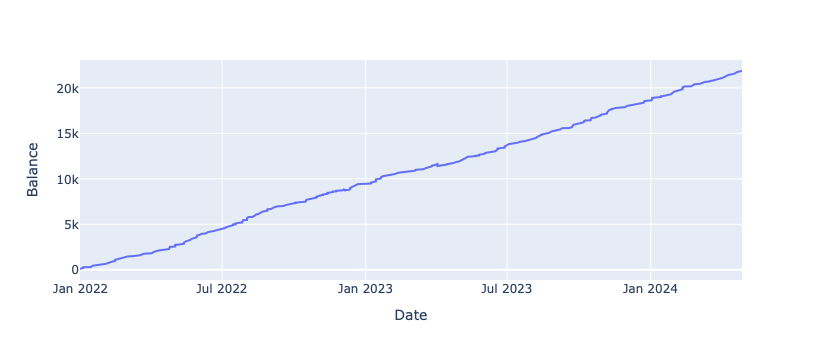

In [22]:
ledg = px.line(ledgers["Expenses:Groceries"], x="Date", y="Balance")
ledg.show()

In [23]:
monthly_g = dict(zip(ledgers.keys(), [ledgers[ledg].set_index("Date").groupby(by=pd.Grouper(freq='ME')).sum("Incoming Amount") for ledg in ledgers]))
monthly_g["Expenses:Amazon"]

/Users/kdavis10/Library/Caches/pypoetry/virtualenvs/csvb-Ko1fBjPz-py3.12/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



Incoming Amount  Balance
Date                                
2022-01-31           221.00   344.32
2022-02-28            12.99   233.99
2022-03-31            12.99   246.98
2022-04-30           246.74  2221.95
2022-05-31           475.32  6440.19
2022-06-30            14.99   984.03
2022-07-31            75.25  2103.57
2022-08-31            14.99  1074.27
2022-09-30            14.99  1089.26
2022-10-31            68.44  2300.41
2022-11-30            14.99  1172.69
2022-12-31           335.98  3002.35
2023-01-31           100.54  3203.43
2023-02-28            14.99  1624.20
2023-03-31           125.62  5121.42
2023-04-30            30.58  3545.81
2023-05-31            14.99  1795.39
2023-06-30            64.35  5531.81
2023-07-31            14.99  1874.73
2023-08-31            74.90  3884.27
2023-09-30            14.99  1964.62
2023-10-31            14.99  1979.61
2023-11-30            14.99  1994.60
2023-12-31            14.99  2009.59
2024-01-31            29.98  4064.15
2024-02-29            35.96  8272.18
2024-03-31           235.11  6791.88
2024-04-30            17.98  4654.25

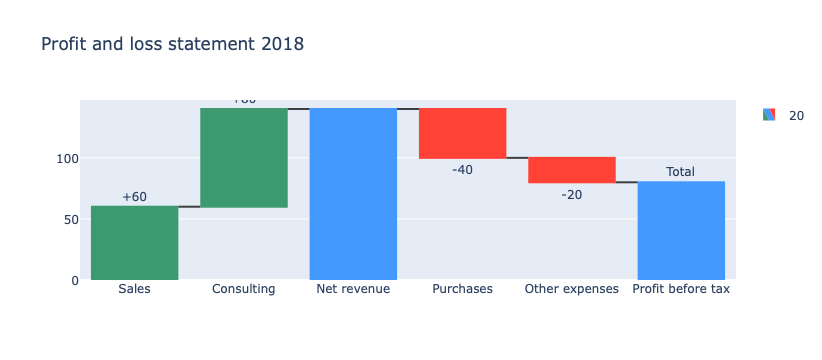

In [31]:
wf = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = ["relative", "relative", "total", "relative", "relative", "total"],
    x = ["Sales", "Consulting", "Net revenue", "Purchases", "Other expenses", "Profit before tax"],
    textposition = "outside",
    text = ["+60", "+80", "", "-40", "-20", "Total"],
    y = [60, 80, 0, -40, -20, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

wf.update_layout(
        title = "Profit and loss statement 2018",
        showlegend = True
)

wf.show()

In [70]:
d = []

for acct in monthly_g:
    try:
        d.append((acct, (monthly_g[acct]["Incoming Amount"]).mean()))
    except KeyError:
        pass

        

In [74]:
pd.Series(index=[t[0] for t in d], data=[t[1] for t in d],name="Mean Monthly Incoming")

Assets:Ally:Savings                 457.547778
Expenses:Recovery                   255.940000
Expenses:Electronics                239.649565
Expenses:Home:Maintenance           212.494400
Expenses:Clothing                   173.272800
Expenses:Reimbursible               178.018824
Expenses:Fitness:ID                 234.782609
Expenses:Auto:Maintenance            46.138947
Liabilities:NDFCU:Credit Card       -22.957931
Expenses:Auto:Registration           43.070417
Expenses:Fitness:Recovery            23.157895
Expenses:Auto:Tolls                  11.602857
Expenses:Projects                   117.029524
Transfer                           -241.512759
Expenses:Fitness                    249.500000
Expenses:Study                       33.575185
Expenses:Medical:Body               115.256429
Income:Notre Dame:Regular         -5784.610714
Expenses:Auto:Insurance             107.476316
Expenses:Subscriptions              148.625862
Expenses:Misc                        10.504286
Expenses:Medi